### Import Libraries

In [1]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
from sklearn.model_selection import train_test_split

import gdown
import zipfile

### Set working directory

In [2]:
#Change working directory to the base folder "ML_BarePass"

while os.path.basename(os.getcwd()) != "ML_BarePass":
    os.chdir((os.path.dirname(os.getcwd())))


### Dowload dataset

#### Dowload from drive

In [3]:
dataset_name = "BrainCancer"

In [4]:
# Google Drive file ID
file_id = '1iLuOLiStCg8Nb8cxxaP4vrSj-lo5LqPx'

# Construct the download URL
download_url = f'https://drive.google.com/uc?id={file_id}'

# Define the target directory
target_directory = 'data/raw'

# Ensure the target directory exists
os.makedirs(target_directory, exist_ok=True)

# Specify the output filename with the full path
output_filename = os.path.join(target_directory, f'{dataset_name}.zip')

# Check if the file already exists
if not os.path.exists(output_filename):
    # Download the file
    gdown.download(download_url, output=output_filename, quiet=False)
else:
    print(f"The file '{output_filename}' already exists. Skipping download.")

The file 'data/raw/BrainCancer.zip' already exists. Skipping download.


#### Unzip dataset zip file

In [5]:
output_filename

'data/raw/BrainCancer.zip'

In [6]:
import os
import zipfile

def extract_and_rename(zip_file_path, target_directory, new_folder_name):
    # Ensure the target directory exists
    os.makedirs(target_directory, exist_ok=True)
    
    # Open the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the target directory
        zip_ref.extractall(target_directory)

In [7]:
extract_and_rename(output_filename, target_directory, dataset_name)

In [8]:
import os

old_folder = "data/raw/Brain Cancer"
new_folder = "data/raw/BrainCancer"

if os.path.isdir(old_folder):  # Ensure it's a directory
    if not os.path.exists(new_folder):  # Ensure target doesn't exist
        os.system(f"mv '{old_folder}' '{new_folder}'")
        print(f"Renamed '{old_folder}' to '{new_folder}'")
    else:
        print(f"Error: '{new_folder}' already exists.")
else:
    print(f"Error: '{old_folder}' does not exist or is not a directory.")


Error: 'data/raw/BrainCancer' already exists.


### Create dataframe

In [9]:
raw_data_dir = os.path.join(target_directory,dataset_name)

# Collect file paths and labels using os.walk()
paths, labels = [], []

if os.path.isdir(raw_data_dir):
    for root, _, files in os.walk(raw_data_dir):
        label = os.path.basename(root)  # The last folder name is the label
        if root != raw_data_dir:  # Ensure we don't include the root folder itself
            paths.extend(os.path.join(root, file) for file in files)
            labels.extend([label] * len(files))



# Create DataFrame
df = pd.DataFrame({'filepath': paths, 'labels': labels})

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.iloc[:1500]

In [10]:
df.sample(10)

,filepath,labels
395,data/raw/BrainCancer/brain_tumor/brain_tumor_1...,brain_tumor
1234,data/raw/BrainCancer/brain_glioma/brain_glioma...,brain_glioma
437,data/raw/BrainCancer/brain_glioma/brain_glioma...,brain_glioma
1167,data/raw/BrainCancer/brain_glioma/brain_glioma...,brain_glioma
398,data/raw/BrainCancer/brain_menin/brain_menin_1...,brain_menin
1087,data/raw/BrainCancer/brain_menin/brain_menin_0...,brain_menin
645,data/raw/BrainCancer/brain_menin/brain_menin_2...,brain_menin
1321,data/raw/BrainCancer/brain_tumor/brain_tumor_1...,brain_tumor
508,data/raw/BrainCancer/brain_tumor/brain_tumor_1...,brain_tumor
1060,data/raw/BrainCancer/brain_glioma/brain_glioma...,brain_glioma


### Statistics

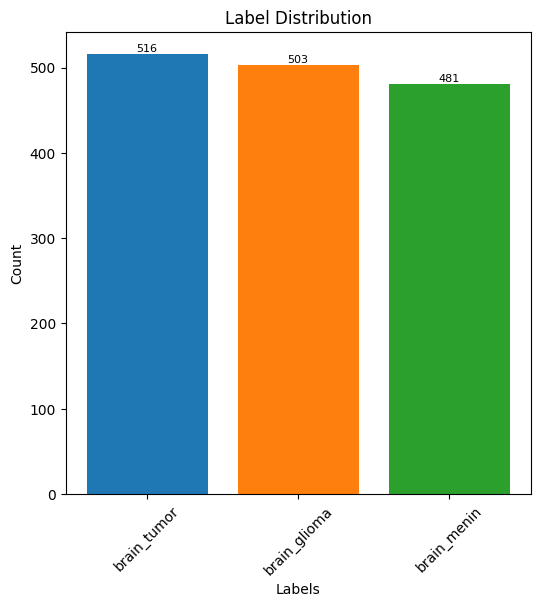

In [11]:
count=df['labels'].value_counts().reset_index()
count.columns=['labels','count']

# Generating unique colors for each bar
colors = plt.colormaps.get_cmap('tab10')

# Creating a vertical bar plot with different colors
plt.figure(figsize=(6, 6))
bars = plt.bar(count['labels'], count['count'], color=[colors(i) for i in range(len(count))])

# Adding numbers on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()), 
             ha='center', va='bottom', fontsize=8)

# Labels and title
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.xticks(rotation=45)

# Show the plot
plt.show()


The dataset is balanced 

### Plot some images

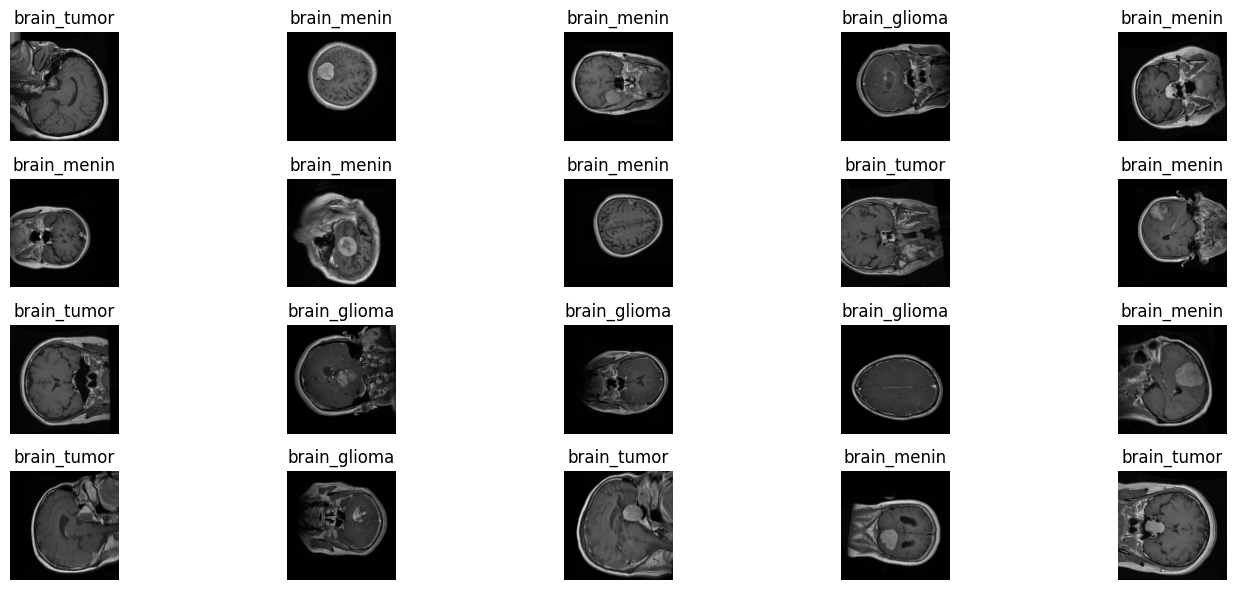

In [12]:
# Number of images to display
N = 20

# Sampling N images
samples = df.sample(N, random_state=42)

# Calculate the number of rows needed
ncols = 5
nrows = (N + ncols - 1) // ncols  # Equivalent to math.ceil(N / ncols)

# Creating a figure for displaying images
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6))

# Flatten axes for easy iteration
axes = axes.flatten()

# Displaying images with labels
for i, (idx, row) in enumerate(samples.iterrows()):
    try:
        img = Image.open(row['filepath'])
        axes[i].imshow(img)
        axes[i].set_title(f"{row['labels']}")
        axes[i].axis('off')
    except Exception as e:
        axes[i].set_title("Error loading image")
        axes[i].axis('off')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### Preprocessing: Cropping + Resizing

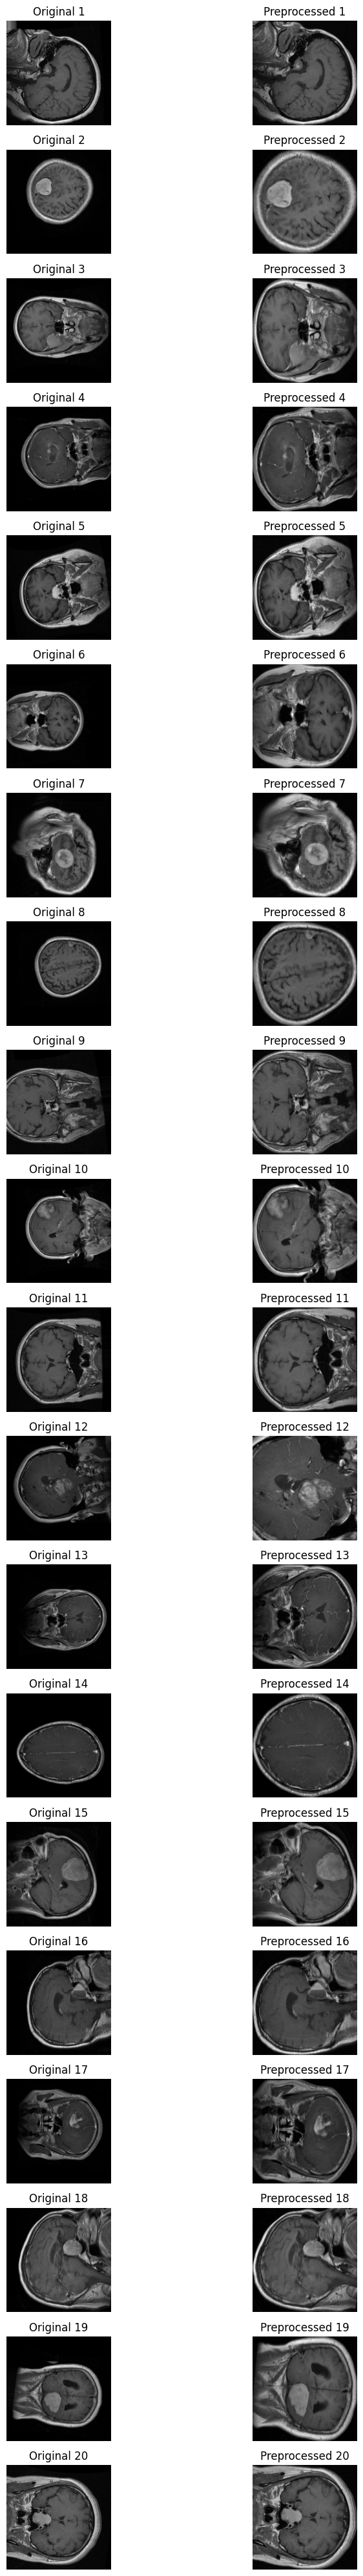

In [13]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io, color
from src.data.preprocess import crop_brain_contour

# Number of samples to visualize
N = len(samples)

# Create subplots
fig, axes = plt.subplots(N, 2, figsize=(10, 2 * N))

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Loop through each sample image
for i, image_path in enumerate(samples.filepath.values):
    try:
        # Load image and convert to grayscale
        original_image = io.imread(image_path)
        original_image = color.rgb2gray(original_image)
        original_image = (original_image * 255).astype(np.uint8)  # Normalize to uint8
        
        # Apply the cropping function
        cropped_image = crop_brain_contour(original_image)

        # Convert to PIL image for Torch processing
        cropped_pil = Image.fromarray(cropped_image)

        # Apply transformations
        image_tensor = transform(cropped_pil)

        # Convert back to NumPy for visualization
        cropped_np = image_tensor.squeeze(0).numpy()  # Remove batch dimension for grayscale

        # Plot original image
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f"Original {i+1}")
        axes[i, 0].axis('off')

        # Plot preprocessed image
        axes[i, 1].imshow(cropped_np, cmap='gray')
        axes[i, 1].set_title(f"Preprocessed {i+1}")
        axes[i, 1].axis('off')

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### Load dataset

In [14]:
from src.data.make_dataset import load_data

/home/nguyen/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nguyen/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/nguyen/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAU

In [15]:
dataset = load_data(df)

Loading images and extracting features...


1500it [00:49, 30.29it/s]


### Splitting dataset

In [16]:
X = dataset['fused_feature']
y = dataset['labels']

In [17]:
X.shape

(1500, 26368)

In [18]:
y.shape

(1500,)

In [20]:
import torch
from torch.utils.data import random_split
import numpy as np

def stratified_split(X, y, test_size=0.2, random_seed=42):
    """
    Perform a stratified train-test split using PyTorch.

    Args:
    - X (torch.Tensor): Input feature tensor.
    - y (torch.Tensor): Labels tensor.
    - test_size (float): Proportion of the dataset to allocate to test set.
    - random_seed (int): Seed for reproducibility.

    Returns:
    - X_train, X_test, y_train, y_test: Train-test split tensors.
    """
    torch.manual_seed(random_seed)

    # Convert to NumPy for stratification
    y_np = y
    X_np = X

    # Perform stratified split using sklearn
    from sklearn.model_selection import train_test_split
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
        X_np, y_np, test_size=test_size, random_state=random_seed, stratify=y_np
    )

    # Convert back to PyTorch tensors
    X_train, X_test = torch.tensor(X_train_np, dtype=torch.float32), torch.tensor(X_test_np, dtype=torch.float32)
    y_train, y_test = torch.tensor(y_train_np, dtype=torch.long), torch.tensor(y_test_np, dtype=torch.long)

    return X_train, X_test, y_train, y_test

# Example usage (assuming X and y are PyTorch tensors)
X_train, X_test, y_train, y_test = stratified_split(X, y, test_size=0.2)

# Check the sizes of the splits
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Class distribution in training and test sets
def print_class_distribution(y, dataset_name):
    unique, counts = torch.unique(y, return_counts=True)
    print(f"\nClass distribution in {dataset_name}:")
    for class_label, count in zip(unique.tolist(), counts.tolist()):
        print(f"Class {class_label}: {count} samples")

print_class_distribution(y_train, "y_train")
print_class_distribution(y_test, "y_test")


Training set size: 1200 samples
Test set size: 300 samples

Class distribution in y_train:
Class 0: 402 samples
Class 1: 385 samples
Class 2: 413 samples

Class distribution in y_test:
Class 0: 101 samples
Class 1: 96 samples
Class 2: 103 samples


In [22]:
save_dir = os.path.join(os.getcwd(),'data','processed')

train_folder = os.path.join(save_dir,'train')
# val_folder = os.path.join(save_dir,'val')
test_folder = os.path.join(save_dir,'test')

os.makedirs(train_folder,exist_ok=True)
# os.makedirs(val_folder,exist_ok=True)
os.makedirs(test_folder,exist_ok=True)


X_train_file = os.path.join(train_folder,'X_train.npy')
y_train_file = os.path.join(train_folder,'y_train.npy')

# X_val_file = os.path.join(val_folder,'X_val.npy')
# y_val_file = os.path.join(val_folder,'y_val.npy')

X_test_file = os.path.join(test_folder,'X_test.npy')
y_test_file = os.path.join(test_folder,'y_test.npy')

# Save training and test sets
np.save(X_train_file, X_train)
np.save(y_train_file, y_train)

# np.save(X_val_file, X_val)
# np.save(y_val_file, y_val)

np.save(X_test_file, X_test)
np.save(y_test_file, y_test)

### Models

In [1]:
import numpy as np
import os
#Change working directory to the base folder "ML_BarePass"

while os.path.basename(os.getcwd()) != "ML_BarePass":
    os.chdir((os.path.dirname(os.getcwd())))

save_dir = os.path.join(os.getcwd(),'data','processed')

train_folder = os.path.join(save_dir,'train')
# val_folder = os.path.join(save_dir,'val')
test_folder = os.path.join(save_dir,'test')

X_train_file = os.path.join(train_folder,'X_train.npy')
y_train_file = os.path.join(train_folder,'y_train.npy')

X_test_file = os.path.join(test_folder,'X_test.npy')
y_test_file = os.path.join(test_folder,'y_test.npy')

# To load the data later
X_train = np.load(X_train_file)
y_train = np.load(y_train_file)

X_test = np.load(X_test_file)
y_test = np.load(y_test_file)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.data import BrainCancerDataset
from src.models import load_model, SimpleMLP, DecisionTreeModel
from src.models.train_model import train_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [3]:
# Apply StandardScaler & PCA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # Retain 95% variance
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Convert data into PyTorch DataLoader
batch_size = 32
train_dataset = BrainCancerDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
model_name="decision_tree"
# [mlp, decision_tree, ]
model = load_model(model_name, input_dim=X_train.shape[1], num_classes=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# ==========================
# Initialize & Train Model
# ==========================


if isinstance(model, SimpleMLP):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
else:
    criterion = optimizer = None  # Decision Tree does not need them

# Train the model
print(f"Training {model_name} model...")
train_model(model, train_loader, criterion, optimizer, device, epochs=100)

Training decision_tree model...
Decision Tree training complete.
Decision Tree Log Loss: 0.0000, Training Accuracy: 1.0000
